In [ ]:
# Import the tools we need
from spacerocks import SpaceRock, Units

import numpy as np
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.jplhorizons import Horizons

import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv('JT_test/trojans_JT_1.csv')

In [50]:
df.head()

,Unnamed: 0,name,a,e,inc,node,arg,M,epoch,x,y,z,vx,vy,vz,Ln
0,0,1d0253c3f5774331aceb42dc7b60b719,5.321871,0.002172,43.912646,188.973701,6.210759,66.870003,2459305.5,-0.936093,-3.862524,3.532543,0.007304,-0.000421,0.001497,L5
1,1,37fb40a75d274b52bda15c76fe54193b,5.148701,0.192996,5.408546,333.830707,184.268819,78.287761,2459305.5,-1.007110,-5.015847,-0.468265,0.007021,-0.002917,0.000045,L5
2,2,a23739246a3d46c6b1231331ca31f6f9,5.308419,0.061536,2.315690,203.024324,91.428716,327.106078,2459305.5,-1.094908,-4.917403,0.165694,0.007725,-0.001430,0.000175,L5
3,3,0c484f562a374ad49a74ee67dedd8ce2,5.189165,0.027632,24.044154,276.849585,75.156199,295.676109,2459305.5,1.248288,-4.967756,0.288619,0.006689,0.002058,0.003072,L5
4,4,53bc8df180cc4b06a61881c1fbf5a2a6,5.362790,0.055035,33.386207,102.490726,154.997589,1.351095,2459305.5,-0.641590,-4.902519,1.111610,0.006548,-0.001766,-0.003961,L5


In [51]:
rocks = SpaceRock(a=df.a, e=df.e, inc=df.inc, node=df.node, arg=df.arg, M=df.M, epoch=df.epoch)

In [52]:
date = Time('2023-08-11 06:00', scale='utc', format='iso')

units = Units()
units.timescale = 'utc'
prop = rocks.analytic_propagate(epoch=date.jd)
obs = prop.observe(obscode='500')    # compute sky positions as seen from the earth geocenter

pos = SkyCoord(obs.ra.deg, obs.dec.deg, frame='icrs', unit=(u.deg, u.deg))

0.0


In [53]:
# Moon and Jupiter from Horizons
startdate = Time('2023-08-11 06:00', scale='utc', format='iso')
enddate = Time('2023-08-11 06:30:00', scale='utc', format='iso')
Salina_KS = {'lat':37.779557, 'lon':-97.618487, 'elevation':864}   # Salina, Kansas
Jupiter_ID, moon_ID = '599', '301'

#observer_loc = Salina_KS
observer_loc = 'W84'     # observatory code for CTIO
jupiter = Horizons(id=Jupiter_ID, location=observer_loc,
                epochs={'start':startdate.iso, 
                        'stop':enddate.iso, 
                        'step':'1h'}).ephemerides().to_pandas()


moon = Horizons(id=moon_ID, location=observer_loc,
                epochs={'start':startdate.iso, 
                        'stop':enddate.iso, 
                        'step':'1h'}).ephemerides().to_pandas()


In [54]:
pos_moon = SkyCoord(moon.RA[0], moon.DEC[0], frame='icrs', unit=(u.deg, u.deg))

In [57]:
JT1 = SkyCoord(340.000546, -8.439750, frame='icrs', unit=(u.deg, u.deg))  # telescope pointing on 20230811

/var/folders/wn/xn44zh2d4q94055t5mqw7c180000gs/T/ipykernel_16798/97112978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ra[ra>180] -= 360


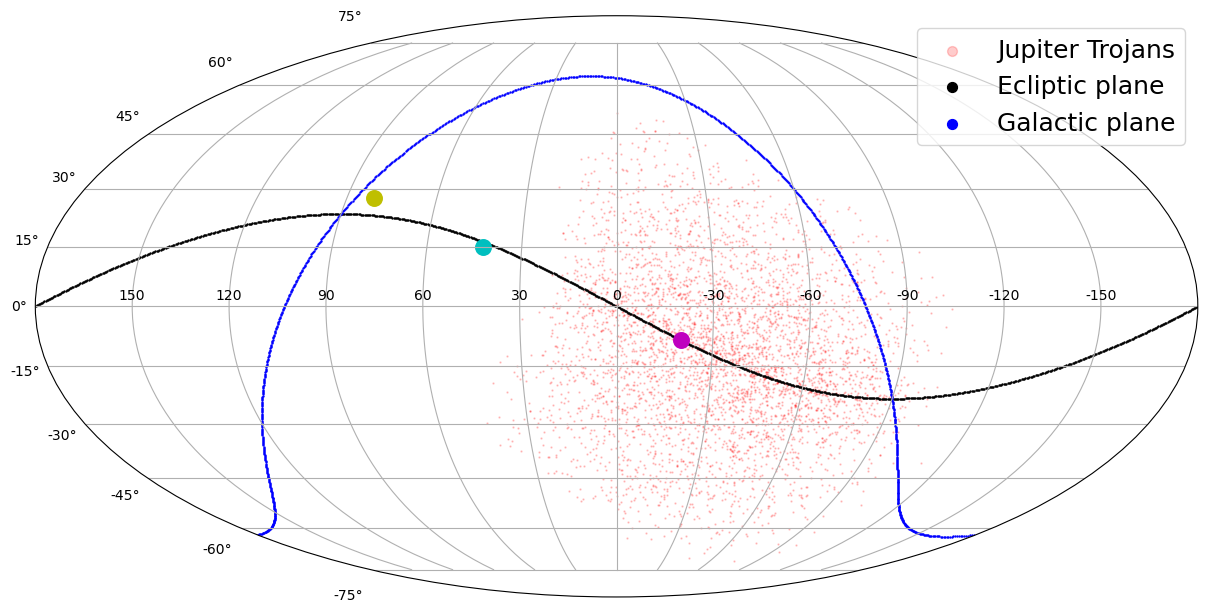

In [68]:
# Helper function for coordinate conversion
def radec2project(ra, dec):
    ra[ra>180] -= 360
    return (-np.radians(ra)), np.radians(dec)

ecliptic = SkyCoord(np.linspace(0,360,1000), np.zeros(1000), unit=(u.deg, u.deg), frame='geocentrictrueecliptic').transform_to('icrs')
galactic = SkyCoord(np.linspace(0,360,1000), np.zeros(1000), unit=(u.deg, u.deg), frame='galactic').transform_to('icrs')

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111, projection="mollweide")
x, y = radec2project(obs.ra.deg, obs.dec.deg)
ax.scatter(x, y, marker='.', s=2, color='r', alpha=0.2, label='Jupiter Trojans')
x, y = radec2project(ecliptic.ra.deg, ecliptic.dec.deg)
ax.scatter(x, y, marker='.',color='k', s=2, label='Ecliptic plane')
x, y = radec2project(galactic.ra.deg, galactic.dec.deg)
ax.scatter(x, y, marker='.', s=2,color='b', label='Galactic plane')
x, y = radec2project(jupiter.RA, jupiter.DEC)
ax.scatter(x[0], y[0], marker='.', s=500, color='c')
x, y = radec2project(moon.RA, moon.DEC)
ax.scatter(x[0], y[0], marker='.', s=500, color='y')
x, y = radec2project(np.array([JT1.ra.deg]), np.array([JT1.dec.deg]))
ax.scatter(x[0], y[0], marker='.', s=500, color='m')

ax.set_xticklabels((150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150))
ax.legend(fontsize=18, markerscale=10)
plt.grid(True)

Text(0.5, 0, 'Node')

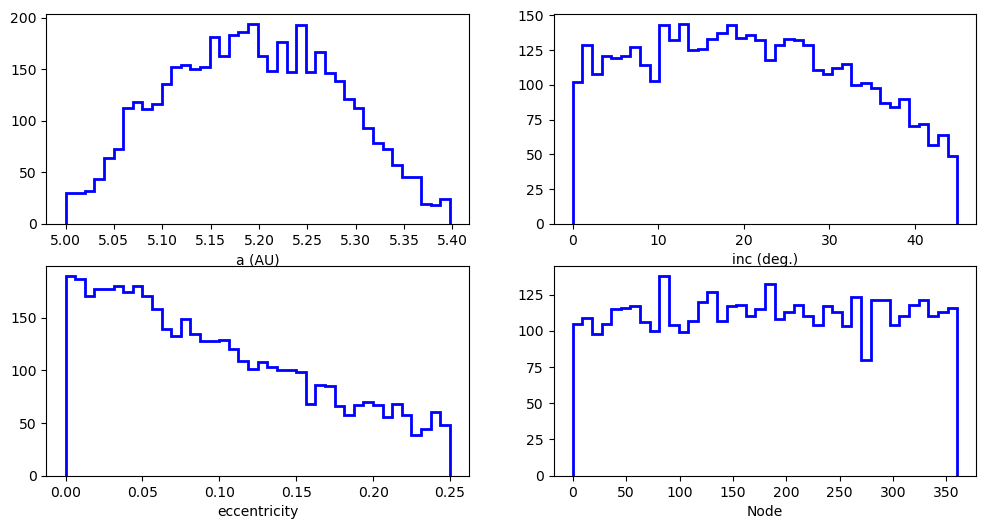

In [65]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
n, bins, patches = axs[0][0].hist(df.a, bins=40, histtype='step', lw=2, color='b')
axs[0][0].set_xlabel('a (AU)')
n, bins, patches = axs[0][1].hist(df.inc, bins=40, histtype='step', lw=2, color='b')
axs[0][1].set_xlabel('inc (deg.)')
n, bins, patches = axs[1][0].hist(df.e, bins=40, histtype='step', lw=2, color='b')
axs[1][0].set_xlabel('eccentricity')
n, bins, patches = axs[1][1].hist(df.node, bins=40, histtype='step', lw=2, color='b')
axs[1][1].set_xlabel('Node')